             Volume          vw        Open       Close        High  \
count  2.440000e+02  244.000000  244.000000  244.000000  244.000000   
mean   5.753002e+07  172.446657  172.256127  172.537746  173.814386   
std    1.442773e+07   17.383784   17.505511   17.359960   17.272158   
min    2.401840e+07  125.725000  126.010000  125.020000  127.770000   
25%    4.760209e+07  161.831375  161.605000  162.277500  162.442500   
50%    5.479968e+07  175.492900  175.245000  175.475000  177.024500   
75%    6.519576e+07  186.998450  187.047500  187.492500  188.180000   
max    1.124167e+08  198.287200  198.020000  198.110000  199.620000   

              Low             n      Return  Cumulative Return  
count  244.000000  2.440000e+02  243.000000         243.000000  
mean   170.990513  5.782900e+05    0.001860           0.381091  
std     17.528205  1.124803e+05    0.012906           0.136923  
min    124.170000  3.359460e+05   -0.064445          -0.000400  
25%    161.080750  5.096518e+05   -

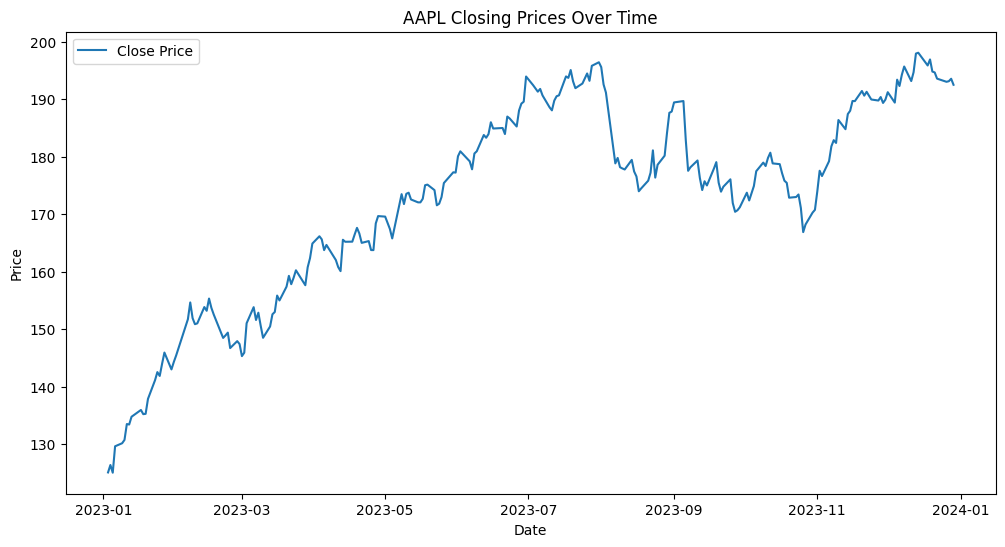

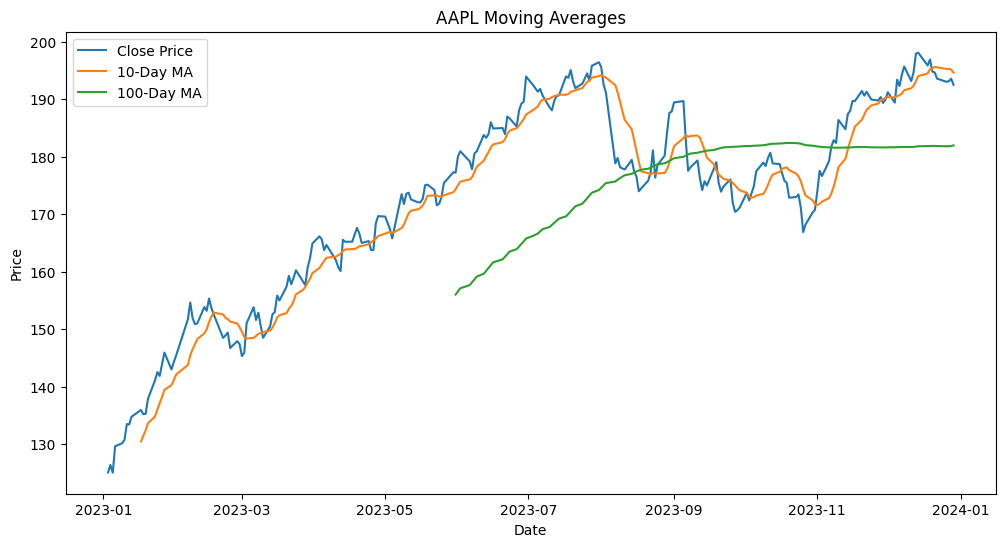

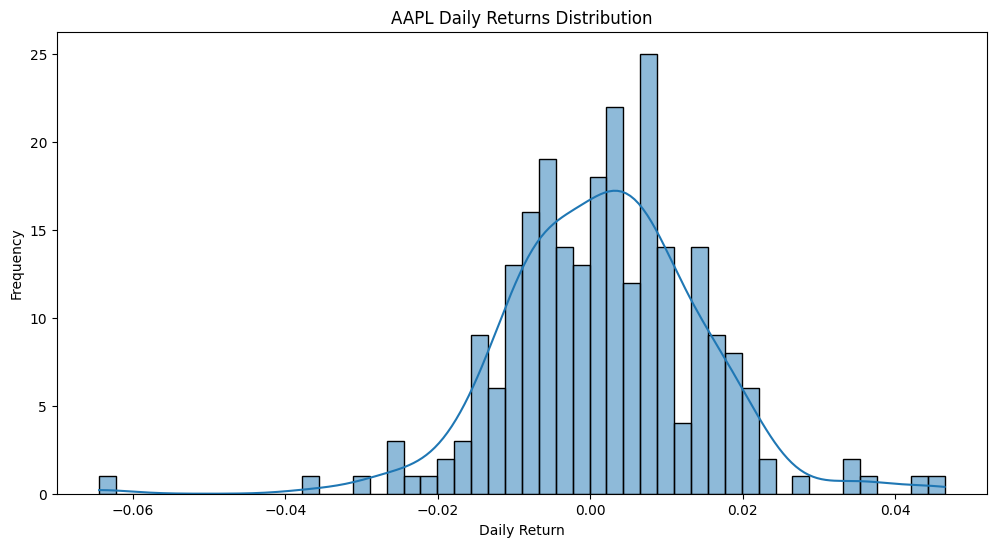

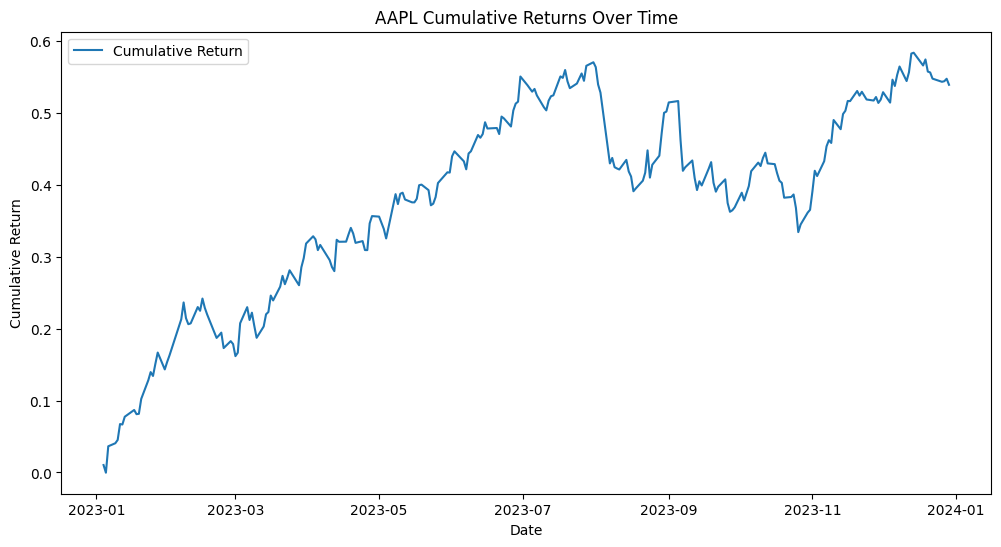

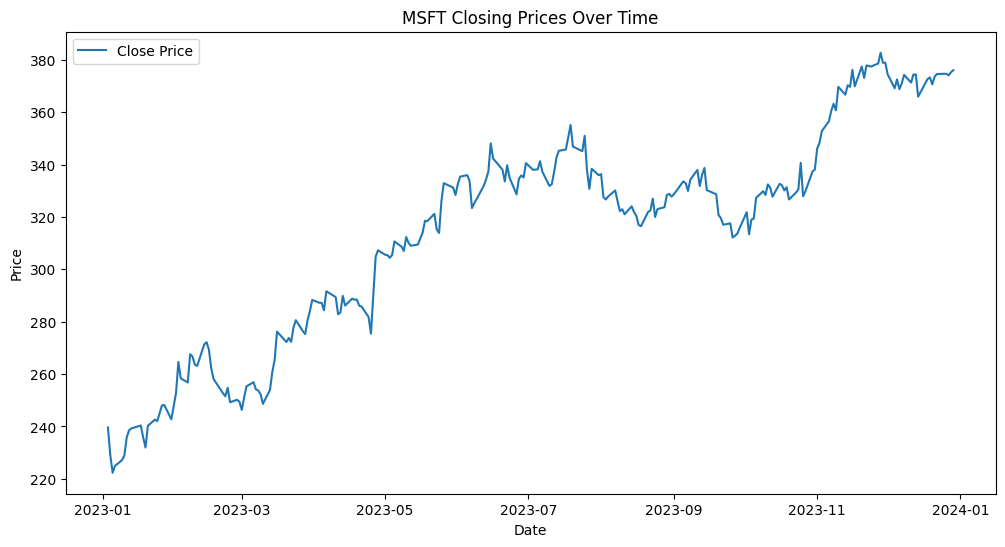

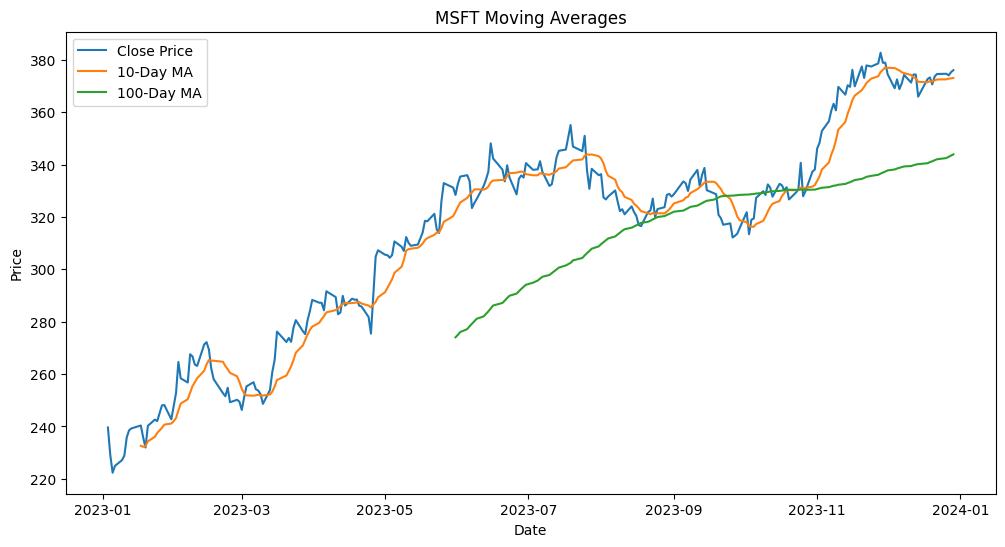

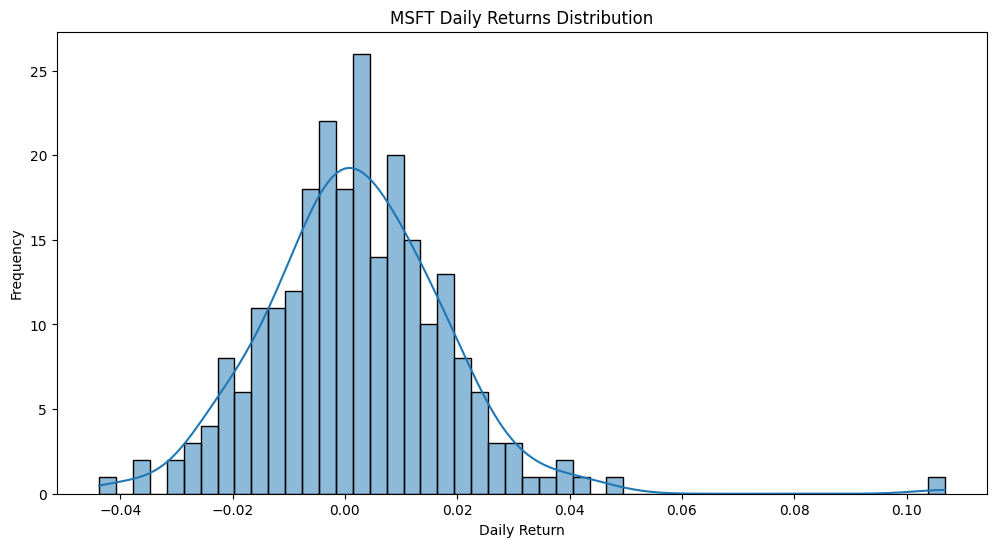

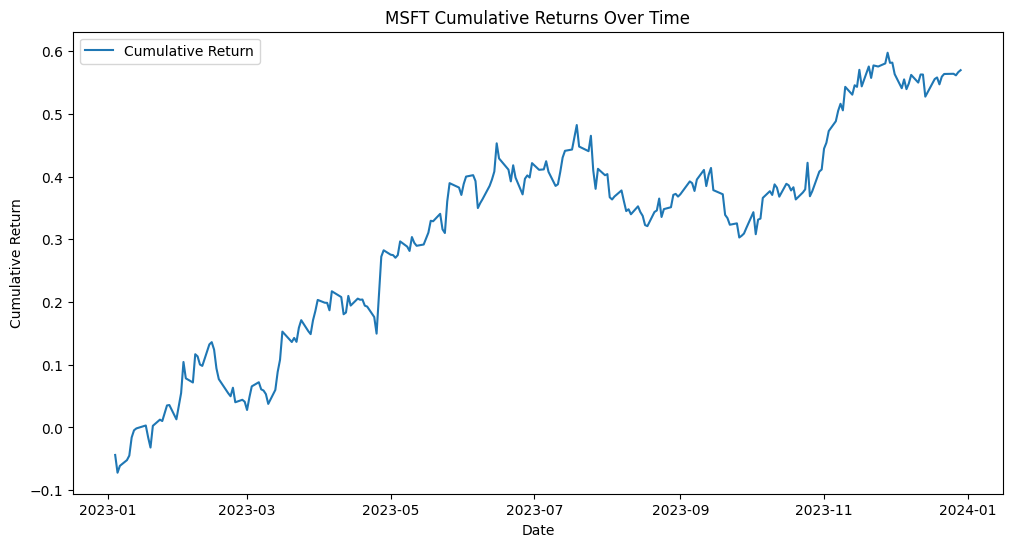

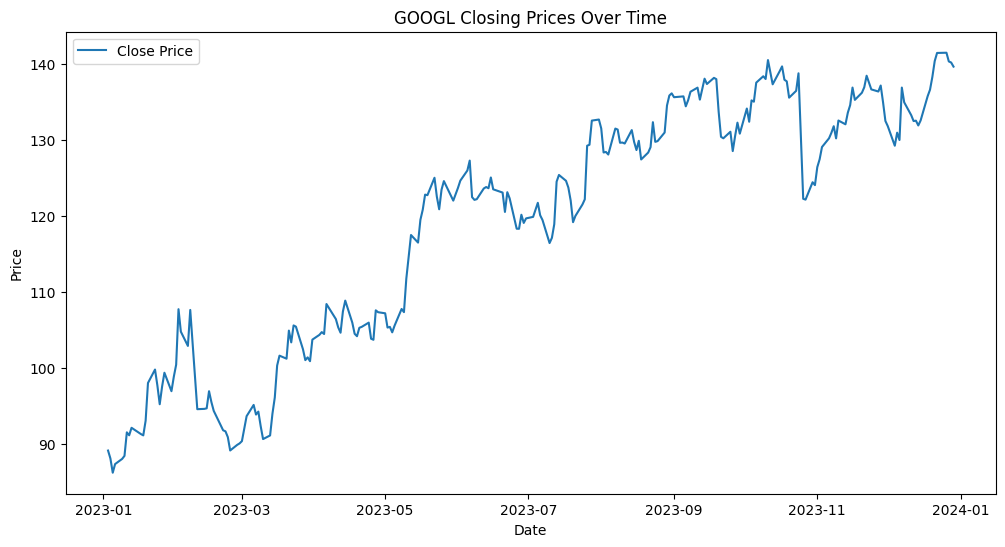

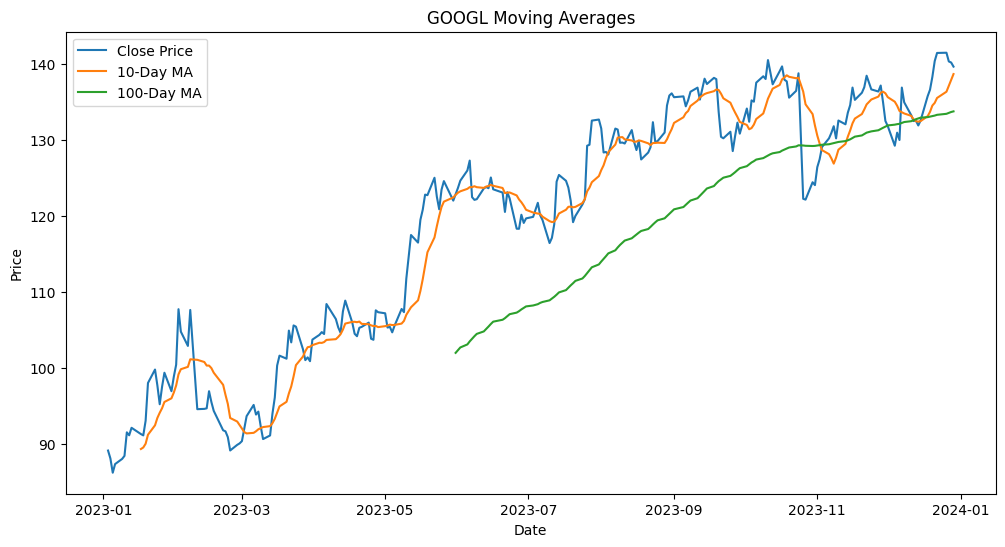

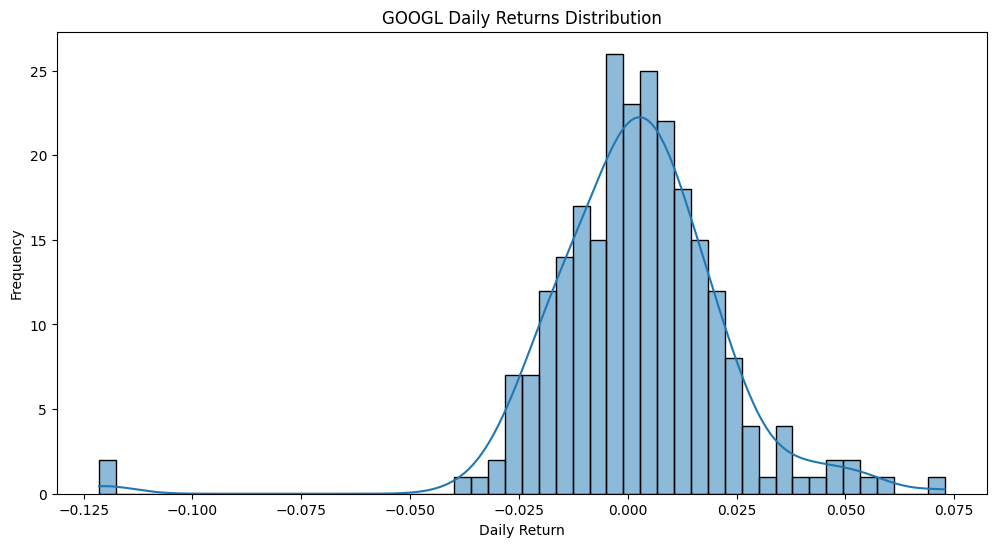

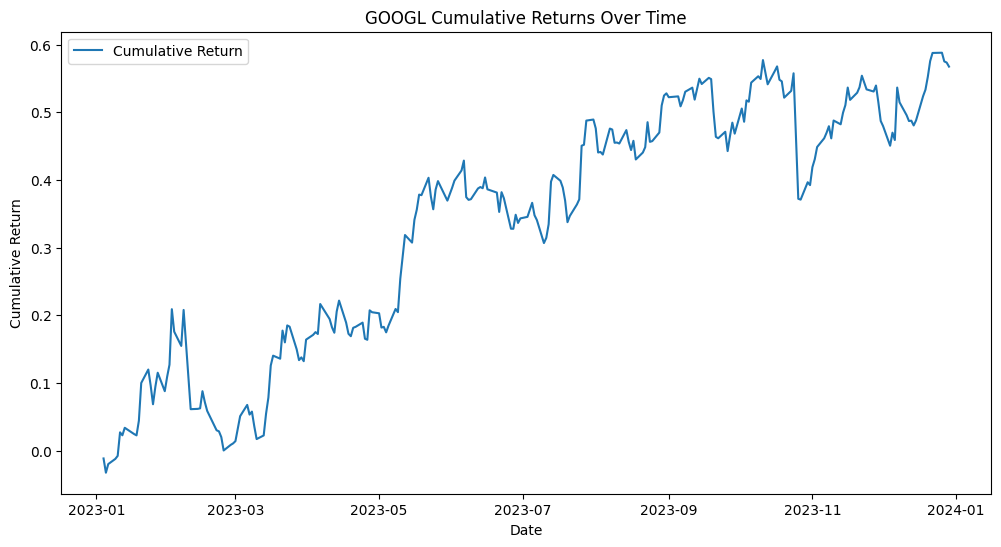

In [69]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pyodbc
from prophet import Prophet
import os
from dotenv import load_dotenv

load_dotenv()
# Define API Key and endpoint for Polygon.io
api_key = os.environ['API_KEY']
base_url = 'https://api.polygon.io'

# Function to fetch data from Polygon.io
def fetch_data(symbol, multiplier, timespan, from_date, to_date):
    url = f"{base_url}/v2/aggs/ticker/{symbol}/range/{multiplier}/{timespan}/{from_date}/{to_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching data for {symbol}: {response.status_code}")
        return None

# Define parameters for the API call
stocks = ['AAPL', 'MSFT', 'GOOGL']
etf = 'SPY'  # Example ETF symbol
forex_pair = 'EURUSD'  # Example Forex pair
multiplier = 1
timespan = 'day'
from_date = '2023-01-01'
to_date = '2023-12-31'
risk_free_rate = 0.01  # Example risk-free rate for Sharpe Ratio calculation

# Function to process data into a DataFrame
def process_data(data, symbol):
    df = pd.DataFrame(data['results'])
    df['t'] = pd.to_datetime(df['t'], unit='ms').dt.date
    df.rename(columns={'t': 'Date', 'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume'}, inplace=True)
    df['Symbol'] = symbol
    return df

# Data Quality and Validation functions
def clean_data(df):
    # Handle missing values
    df.dropna(inplace=True)

    # Handle outliers by removing rows where any column is beyond 3 standard deviations from the mean
    df = df[(np.abs(df[['Open', 'High', 'Low', 'Close', 'Volume']].apply(lambda x: (x - x.mean()) / x.std())) < 3).all(axis=1)]
    
    return df

def transform_data(df):
    # Normalize data formats and convert time zones if necessary (assuming dates are already normalized)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    
    # Add additional calculated columns
    df['Return'] = df['Close'].pct_change()
    df['Cumulative Return'] = (1 + df['Return']).cumprod() - 1
    
    return df

def validate_data(df):
    # Check data against known benchmarks and verify through summary statistics
    print(df.describe())
    print(f"Missing values: {df.isnull().sum().sum()}")
    print(f"Number of duplicates: {df.duplicated().sum()}")

    return df

# Analysis functions
def calculate_metrics(df):
    metrics = {}
    
    # Total Return
    metrics['Total Return'] = df['Cumulative Return'].iloc[-1]
    
    # Annualized Return
    num_years = (df.index[-1] - df.index[0]).days / 365.25
    metrics['Annualized Return'] = (1 + metrics['Total Return'])**(1 / num_years) - 1
    
    # Volatility
    metrics['Volatility'] = df['Return'].std() * np.sqrt(252)  # Annualized volatility
    
    # Sharpe Ratio
    metrics['Sharpe Ratio'] = (metrics['Annualized Return'] - risk_free_rate) / metrics['Volatility']
    
    # Moving Averages
    df['10-Day MA'] = df['Close'].rolling(window=10).mean()
    df['100-Day MA'] = df['Close'].rolling(window=100).mean()
    
    return metrics, df

def calculate_beta(df, market_df):
    # Align dataframes by date
    combined_df = df[['Return']].merge(market_df[['Return']], left_index=True, right_index=True, suffixes=('', '_Market'))
    
    # Calculate covariance between stock returns and market returns
    covariance = np.cov(combined_df['Return'][1:], combined_df['Return_Market'][1:])[0][1]
    market_variance = combined_df['Return_Market'][1:].var()
    beta = covariance / market_variance
    
    return beta

# Fetch, process, and validate data for each stock
all_data = {}
for symbol in stocks:
    data = fetch_data(symbol, multiplier, timespan, from_date, to_date)
    if data:
        df = process_data(data, symbol)
        df = clean_data(df)
        df = transform_data(df)
        df = validate_data(df)
        metrics, df = calculate_metrics(df)
        all_data[symbol] = {'data': df, 'metrics': metrics}

# Fetch, process, and validate data for the ETF
etf_data = fetch_data(etf, multiplier, timespan, from_date, to_date)
if etf_data:
    etf_df = process_data(etf_data, etf)
    etf_df = clean_data(etf_df)
    etf_df = transform_data(etf_df)
    etf_df = validate_data(etf_df)
    etf_metrics, etf_df = calculate_metrics(etf_df)
    all_data[etf] = {'data': etf_df, 'metrics': etf_metrics}

# Calculate Beta for each stock relative to the ETF (market index)
for symbol in stocks:
    beta = calculate_beta(all_data[symbol]['data'], all_data[etf]['data'])
    all_data[symbol]['metrics']['Beta'] = beta

# Fetch, process, and validate data for the Forex pair
forex_data = fetch_data(f'C:{forex_pair}', multiplier, timespan, from_date, to_date)
if forex_data:
    forex_df = process_data(forex_data, forex_pair)
    forex_df = clean_data(forex_df)
    forex_df = transform_data(forex_df)
    forex_df = validate_data(forex_df)
    forex_metrics, forex_df = calculate_metrics(forex_df)
    all_data[forex_pair] = {'data': forex_df, 'metrics': forex_metrics}

# Display the metrics for each asset
for symbol, content in all_data.items():
    print(f"Metrics for {symbol}:")
    for metric, value in content['metrics'].items():
        print(f"{metric}: {value}")
    print("\n")

# Display the first few rows of each DataFrame
for symbol, content in all_data.items():
    print(f"Data for {symbol}:")
    print(content['data'].head())
    print("\n")

# Save the processed data to CSV files
#for symbol, content in all_data.items():
 #   content['data'].to_csv(f'{symbol}_data.csv')

# Visualization functions
def plot_closing_prices(data, symbol):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Close Price')
    plt.title(f'{symbol} Closing Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def plot_moving_averages(data, symbol):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Close Price')
    plt.plot(data.index, data['10-Day MA'], label='10-Day MA')
    plt.plot(data.index, data['100-Day MA'], label='100-Day MA')
    plt.title(f'{symbol} Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def plot_daily_returns(data, symbol):
    plt.figure(figsize=(12, 6))
    sns.histplot(data['Return'].dropna(), bins=50, kde=True)
    plt.title(f'{symbol} Daily Returns Distribution')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.show()

def plot_cumulative_returns(data, symbol):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Cumulative Return'], label='Cumulative Return')
    plt.title(f'{symbol} Cumulative Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.show()

# Example visualizations for each stock
for symbol in stocks:
    data = all_data[symbol]['data']
    plot_closing_prices(data, symbol)
    plot_moving_averages(data, symbol)
    plot_daily_returns(data, symbol)
    plot_cumulative_returns(data, symbol)

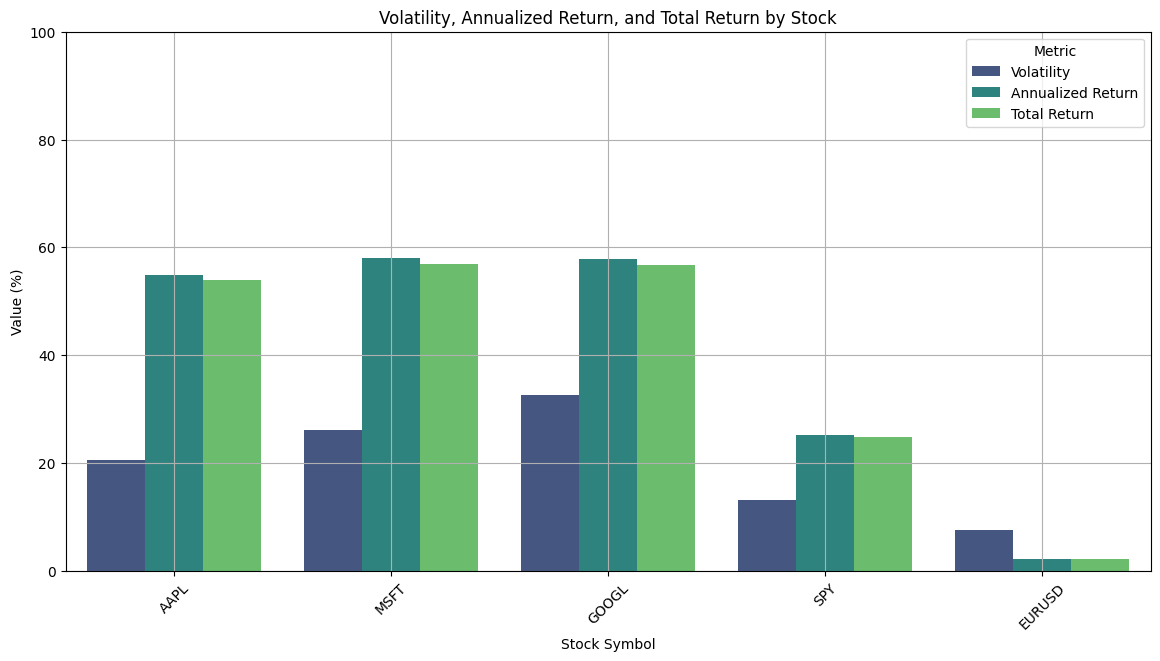

In [29]:
# Convert metrics to percentage
risk_return_data = {
    'Symbol': [],
    'Metric': [],
    'Value (%)': []
}

for symbol, content in all_data.items():
    metrics = content['metrics']
    risk_return_data['Symbol'].append(symbol)
    risk_return_data['Metric'].append('Volatility')
    risk_return_data['Value (%)'].append(metrics['Volatility'] * 100)
    
    risk_return_data['Symbol'].append(symbol)
    risk_return_data['Metric'].append('Annualized Return')
    risk_return_data['Value (%)'].append(metrics['Annualized Return'] * 100)
    
    risk_return_data['Symbol'].append(symbol)
    risk_return_data['Metric'].append('Total Return')
    risk_return_data['Value (%)'].append(metrics['Total Return'] * 100)

risk_return_df = pd.DataFrame(risk_return_data)

# Plotting the combined metrics
plt.figure(figsize=(14, 7))
sns.barplot(data=risk_return_df, x='Symbol', y='Value (%)', hue='Metric', palette='viridis')
plt.title('Volatility, Annualized Return, and Total Return by Stock')
plt.xlabel('Stock Symbol')
plt.ylabel('Value (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Metric')
plt.show()

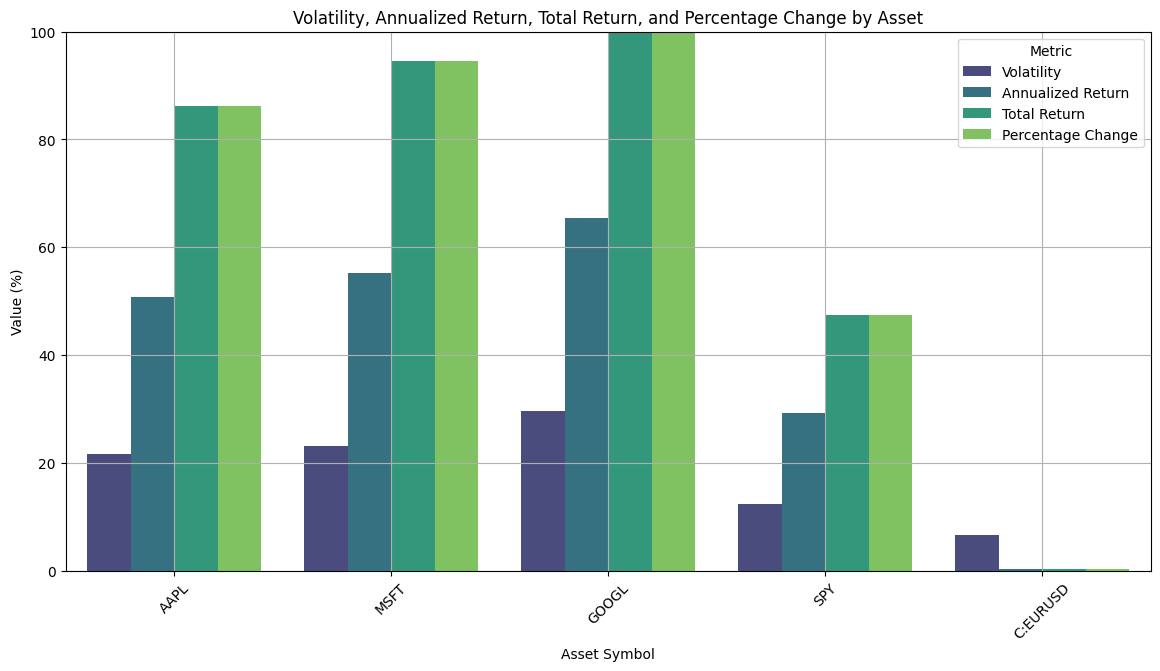

In [35]:


# Plotting the combined metrics
plt.figure(figsize=(14, 7))
sns.barplot(data=risk_return_df, x='Symbol', y='Value (%)', hue='Metric', palette='viridis')
plt.title('Volatility, Annualized Return, Total Return, and Percentage Change by Asset')
plt.xlabel('Asset Symbol')
plt.ylabel('Value (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Metric')
plt.show()

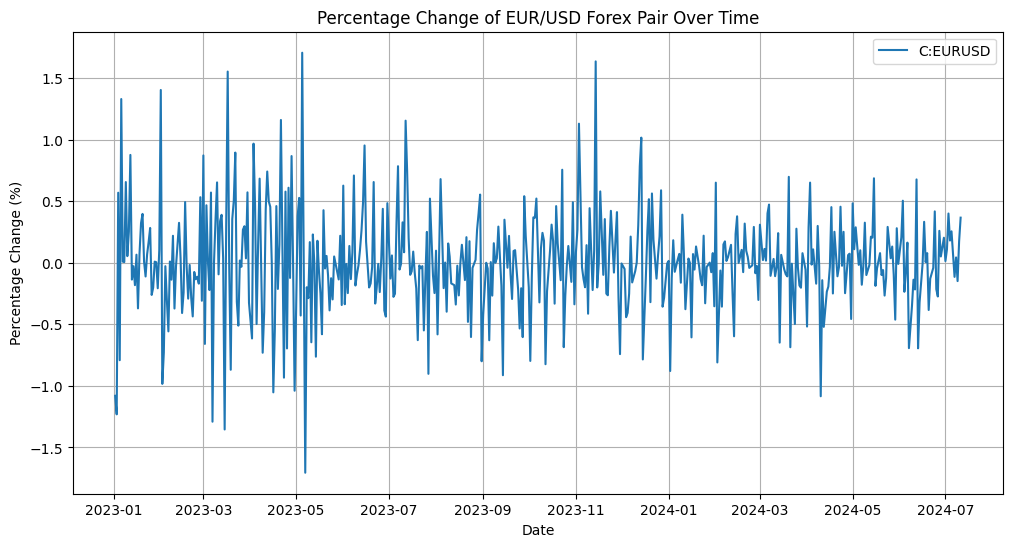

In [38]:
# Define the Forex symbol, start date, and end date
forex_symbol = 'C:EURUSD'
start_date = '2023-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Fetch Forex data
forex_data = fetch_data(forex_symbol, 1, 'day', start_date, end_date)

# Transform and clean the Forex data
if forex_data and 'results' in forex_data:
    forex_df = pd.DataFrame(forex_data['results'])
    forex_df['date'] = pd.to_datetime(forex_df['t'], unit='ms')
    forex_df.rename(columns={'c': 'close', 'h': 'high', 'l': 'low', 'o': 'open', 'v': 'volume'}, inplace=True)
    forex_df = forex_df[['date', 'open', 'high', 'low', 'close', 'volume']]
    
    # Perform data cleaning and transformation
    forex_df = clean_data(forex_df)
    
    # Calculate percentage change
    forex_df['percentage_change'] = forex_df['close'].pct_change() * 100

    # Plotting the percentage change
    plt.figure(figsize=(12, 6))
    plt.plot(forex_df['date'], forex_df['percentage_change'], label=forex_symbol)
    plt.title('Percentage Change of EUR/USD Forex Pair Over Time')
    plt.xlabel('Date')
    plt.ylabel('Percentage Change (%)')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("No data found for the specified symbol and date range.")

plt.figure(figsize=(12, 8))
plt.plot(forex_df['date'], forex_df['open'], label='Open', marker='o')
plt.plot(forex_df['date'], forex_df['high'], label='High', marker='o')
plt.plot(forex_df['date'], forex_df['low'], label='Low', marker='o')
plt.plot(forex_df['date'], forex_df['close'], label='Close', marker='o')
plt.title('Daily Price Movement of EUR/USD Forex Pair')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

In [70]:
import pyodbc

server = 'DESKTOP-TA19NF'
database = 'Project1'
username = 'DESKTOP-TA19NF\\jdangelo'
connection_string = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};UID={username};DATABASE={database};Trusted_Connection=yes;PORT=1433;'

try:
    conn = pyodbc.connect(connection_string)
    print("Connection successful!")
    conn.close()
except pyodbc.Error as ex:
    sqlstate = ex.args[1]
    print(f"Connection failed: {sqlstate}")

Connection failed: [08001] [Microsoft][ODBC Driver 17 for SQL Server]Named Pipes Provider: Could not open a connection to SQL Server [53].  (53) (SQLDriverConnect); [08001] [Microsoft][ODBC Driver 17 for SQL Server]Login timeout expired (0); [08001] [Microsoft][ODBC Driver 17 for SQL Server]Invalid connection string attribute (0); [08001] [Microsoft][ODBC Driver 17 for SQL Server]A network-related or instance-specific error has occurred while establishing a connection to SQL Server. Server is not found or not accessible. Check if instance name is correct and if SQL Server is configured to allow remote connections. For more information see SQL Server Books Online. (53)
